## Note
Fast.ai doesn't support classification for structured data as of 02 Aug 2018, so this notebook simply uses MSE loss as opposed to more classification-oriented loss metrics such as log-loss.

In [100]:
from fastai.structured import *
from fastai.column_data import *
from sklearn.metrics import accuracy_score

PATH = "data/"

## Read data

In [29]:
passengers_train = pd.read_csv(f'{PATH}train.csv', index_col='PassengerId')
passengers_train.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

In [30]:
passengers_test = pd.read_csv(f'{PATH}test.csv', index_col='PassengerId')
passengers = passengers_train.append(passengers_test, sort=False).drop('Survived', axis=1)
passengers.head()

Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0      1      0            113803  53.1000  C123   
5              male  35.0      0      0            373450   8.0500   NaN   

            Embarked  
PassengerId           
1                  S  
2                  C  
3                  S  
4                  S  
5                  S

In [31]:
passengers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB


## Data cleaning

### Extract Title from Name

In [32]:
def get_title(name):
    title_dict = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
    }
    title = name.split(',')[1].split('.')[0].strip()
    return title_dict[title]

titles = passengers.Name.map(get_title)
passengers['Title'] = titles
passengers.head()

Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0      1      0            113803  53.1000  C123   
5              male  35.0      0      0            373450   8.0500   NaN   

            Embarked Title  
PassengerId                 
1                  S    Mr  
2                  C   Mrs  
3                  S  Miss  
4                  S   Mrs  
5                  S    Mr

### Fill in numerical features

In [11]:
ages_and_fares = passengers.groupby(['Sex', 'Pclass', 'Title'])[['Age', 'Fare']]
ages_and_fares = ages_and_fares.apply(lambda chunk: chunk.fillna(chunk.median())).reset_index(['Sex', 'Pclass', 'Title'], drop=True)
ages_and_fares.head()

Age      Fare
PassengerId                
12           58.0   26.5500
62           38.0   80.0000
89           23.0  263.0000
137          19.0   26.2833
178          50.0   28.7125

In [12]:
unchanged = passengers[['Parch', 'SibSp']]
unchanged.head()

Parch  SibSp
PassengerId              
1                0      1
2                0      1
3                0      0
4                0      1
5                0      0

### Assemble all the features

In [34]:
passengers.head()

Pclass                                               Name  \
PassengerId                                                              
1                 3                            Braund, Mr. Owen Harris   
2                 1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                 3                             Heikkinen, Miss. Laina   
4                 1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                 3                           Allen, Mr. William Henry   

                Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
PassengerId                                                                
1              male  22.0      1      0         A/5 21171   7.2500   NaN   
2            female  38.0      1      0          PC 17599  71.2833   C85   
3            female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
4            female  35.0      1      0            113803  53.1000  C123   
5              male  35.0      0      0            373450   8.0500   NaN   

            Embarked Title  
PassengerId                 
1                  S    Mr  
2                  C   Mrs  
3                  S  Miss  
4                  S   Mrs  
5                  S    Mr

In [37]:
categorical_vars = ["Pclass", "Sex", "Cabin", "Embarked", "Title"]
continuous_vars = ["Age", "Fare", "Parch", "SibSp"]

In [57]:
passengers = passengers[categorical_vars + continuous_vars]
passengers[categorical_vars] = passengers[categorical_vars].astype('category')
passengers[continuous_vars] = passengers[continuous_vars].astype('float32')

In [45]:
Xtest = passengers.loc[passengers_test.index]

In [50]:
val_idxs = get_cv_idxs(len(passengers_train), val_pct=0.1)

In [67]:
Xtrain, _, nas, mapper = proc_df(passengers.loc[passengers_train.index], do_scale=True)
ytrain = passengers_train.Survived.astype('float32')

In [62]:
Xtest, _, _, _ = proc_df(passengers.loc[passengers_test.index], do_scale=True, mapper=mapper, na_dict=nas)

### Learning

In [87]:
len(Xtrain)

891

In [104]:
data = ColumnarModelData.from_data_frame(PATH, val_idxs, Xtrain, ytrain, categorical_vars, bs=128, test_df=Xtest)

In [105]:
passengers.Pclass.cat.categories

Int64Index([1, 2, 3], dtype='int64')

In [106]:
embedding_sizes = [(l, min(50, (l+1) // 2)) for c in categorical_vars for l in [len(passengers[c].cat.categories)]]
embedding_sizes

[(3, 2), (2, 1), (186, 50), (3, 2), (6, 3)]

In [111]:
def accuracy(pred, y):
    return accuracy_score(y, pred > 0.5)

In [207]:
learn = data.get_learner(embedding_sizes, len(Xtrain.columns) - len(categorical_vars),
                        0.04, 1, [1000, 500], [0.04, 0.4], y_range=(0,1),
                         metrics=[accuracy])

In [208]:
learn

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(2, 1)
    (2): Embedding(186, 50)
    (3): Embedding(3, 2)
    (4): Embedding(6, 3)
  )
  (lins): ModuleList(
    (0): Linear(in_features=63, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.04)
    (1): Dropout(p=0.4)
  )
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
)

epoch      trn_loss   val_loss   accuracy                                                      
    0      0.253749   0.404494   0.595506  



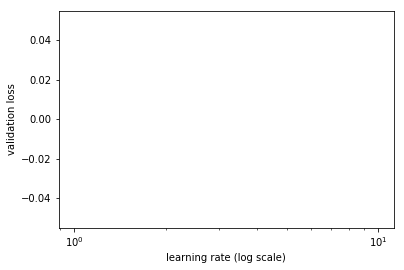

In [209]:
learn.lr_find()
learn.sched.plot()

In [210]:
lr = 1e-3

In [211]:
learn.fit(lr, 5, cycle_len=4, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                      
    0      0.21163    0.145536   0.775281  
    1      0.177029   0.129842   0.808989                                                      
    2      0.16222    0.126017   0.831461                                                      
    3      0.154679   0.126322   0.820225                                                      
    4      0.149217   0.137675   0.797753                                                      
    5      0.144313   0.128769   0.786517                                                      
    6      0.13991    0.122256   0.820225                                                      
    7      0.137656   0.123016   0.786517                                                      
    8      0.134308   0.13039    0.797753                                                      
    9      0.13189    0.127913   0.797753                                                   

    84     0.077557   0.130951   0.842697                                                      
    85     0.077154   0.13752    0.831461                                                      
    86     0.076486   0.128109   0.842697                                                      
    87     0.075676   0.122811   0.853933                                                      
    88     0.07657    0.1252     0.831461                                                      
    89     0.075971   0.133924   0.853933                                                      
    90     0.075254   0.13679    0.842697                                                      
    91     0.074806   0.134135   0.808989                                                      
    92     0.074265   0.133429   0.820225                                                      
    93     0.07468    0.137214   0.853933                                                      
    94     0.074105   0.136789   0.83146

[array([0.13499]), 0.8426966292134831]

### Predict on test set

In [217]:
accuracy(*learn.predict_with_targs())

0.8426966292134831

In [220]:
probs = learn.predict(True)

In [223]:
prediction = pd.DataFrame((probs > 0.5) * 1, index=passengers_test.index, columns=['Survived'])
prediction.head()

Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 0

In [224]:
prediction.to_csv('submission.csv')